In [1]:
pip install pymorphy2

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# import other required libs
import pandas as pd
import numpy as np
import pymorphy2 as pm
import nltk

# viz libs
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import os
import re
from tqdm.notebook import tqdm
import multiprocessing
from multiprocessing import Pool
N_CORES = min(
    multiprocessing.cpu_count(), 
    int(float(os.environ['CPU_LIMIT']))
)

print('cores:', N_CORES)
pd.set_option('display.max_colwidth', 100)

cores: 5


## Bachelors group

In [5]:
df = pd.read_csv('profile_info_gsom_bach.csv')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3431 entries, 0 to 3430
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          3431 non-null   int64  
 1   id                  3431 non-null   int64  
 2   first_name          3431 non-null   object 
 3   last_name           3188 non-null   object 
 4   university_name     499 non-null    object 
 5   education_status    192 non-null    object 
 6   sex                 3431 non-null   int64  
 7   interests           88 non-null     object 
 8   bdate               2729 non-null   object 
 9   city_id             2498 non-null   float64
 10  city_title          2498 non-null   object 
 11  last_seen_platform  3029 non-null   float64
 12  last_seen_time      3029 non-null   object 
dtypes: float64(2), int64(3), object(8)
memory usage: 348.6+ KB


In [7]:
df

,Unnamed: 0,id,first_name,last_name,university_name,education_status,sex,interests,bdate,city_id,city_title,last_seen_platform,last_seen_time
0,0,959,Anna,Chaykina,NaN,NaN,1,NaN,25.4,2.0,Saint Petersburg,4.0,2023-05-22 23:20:17
1,1,1361,Anna,Veselova,NaN,NaN,1,NaN,24.7.1983,2.0,Saint Petersburg,2.0,2023-05-22 19:32:28
2,2,1642,Maxim,Zavitkov,СПбГУ,Alumnus (Bachelor's),2,"Юриспруденция, авиация, театр, психология, философия, экономика, менеджмент, риторика, конфликто...",31.8,2.0,Saint Petersburg,2.0,2023-05-22 17:16:21
3,3,9088,Sergey,Cherepanov,NaN,NaN,2,NaN,23.8.1989,2.0,Saint Petersburg,4.0,2023-05-22 21:37:36
4,4,10615,Darya,Lebedeva,NaN,NaN,1,NaN,15.8,2.0,Saint Petersburg,2.0,2023-05-22 19:47:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3426,3426,757131621,Natalya,Mishulina,NaN,NaN,1,NaN,1.7.2005,NaN,NaN,4.0,2023-05-22 18:39:45
3427,3427,776095130,Rudi,Troya,NaN,NaN,2,NaN,21.1.2000,NaN,NaN,7.0,2023-05-20 23:06:19
3428,3428,787319478,Valeria,Shevchenko,NaN,NaN,1,NaN,30.3.2006,NaN,NaN,2.0,2023-05-22 20:43:42
3429,3429,787549222,Simona,Petrova,NaN,NaN,1,NaN,7.8.2008,2.0,Saint Petersburg,7.0,2023-04-03 09:34:22


In [8]:
df = df.loc[df['last_seen_time'] >= '2022-06-01']

In [9]:
df = df.loc[df['bdate'].str.len() == 9]

In [10]:
curr_time = pd.to_datetime("now")
print(curr_time)

2023-05-29 18:53:14.455522


In [11]:
df['bdate'] = pd.to_datetime(df.bdate, format='%d.%m.%Y')

In [12]:
df

,Unnamed: 0,id,first_name,last_name,university_name,education_status,sex,interests,bdate,city_id,city_title,last_seen_platform,last_seen_time
1,1,1361,Anna,Veselova,NaN,NaN,1,NaN,1983-07-24,2.0,Saint Petersburg,2.0,2023-05-22 19:32:28
3,3,9088,Sergey,Cherepanov,NaN,NaN,2,NaN,1989-08-23,2.0,Saint Petersburg,4.0,2023-05-22 21:37:36
6,6,18619,Oleg,Koresh,NaN,NaN,2,NaN,1987-05-23,2.0,Saint Petersburg,2.0,2023-05-21 17:01:04
9,9,38445,Alina,Borodina,NaN,NaN,1,NaN,1989-02-22,2.0,Saint Petersburg,2.0,2023-05-22 20:20:22
14,14,73458,Maria,Smirnova,NaN,NaN,1,NaN,1980-06-23,2.0,Saint Petersburg,2.0,2023-05-22 10:27:03
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3408,3408,744131146,Anna,Ermeni,СПбГУ,NaN,1,NaN,2003-08-30,2.0,Saint Petersburg,4.0,2023-05-22 19:18:54
3409,3409,744825520,Ivan,Bushuev,NaN,NaN,2,NaN,2004-08-27,NaN,NaN,2.0,2023-05-22 20:14:37
3410,3410,745902835,Madi,Xoja,NaN,NaN,1,NaN,2003-08-10,NaN,NaN,7.0,2023-05-06 15:30:14
3427,3427,776095130,Rudi,Troya,NaN,NaN,2,NaN,2000-01-21,NaN,NaN,7.0,2023-05-20 23:06:19


In [13]:
df['diff_days'] = curr_time - df['bdate']
# for days use 'D' for weeks use 'W', for month use 'M' and for years use 'Y'
df['years_old']=df['diff_days']/np.timedelta64(1,'Y')      
print(df)

      Unnamed: 0         id first_name   last_name university_name  \
1              1       1361       Anna    Veselova             NaN   
3              3       9088     Sergey  Cherepanov             NaN   
6              6      18619       Oleg      Koresh             NaN   
9              9      38445      Alina    Borodina             NaN   
14            14      73458      Maria    Smirnova             NaN   
...          ...        ...        ...         ...             ...   
3408        3408  744131146       Anna      Ermeni           СПбГУ   
3409        3409  744825520       Ivan     Bushuev             NaN   
3410        3410  745902835       Madi        Xoja             NaN   
3427        3427  776095130       Rudi       Troya             NaN   
3428        3428  787319478    Valeria  Shevchenko             NaN   

     education_status  sex interests      bdate  city_id        city_title  \
1                 NaN    1       NaN 1983-07-24      2.0  Saint Petersburg   
3  

In [14]:
df = df.loc[df['years_old'] <= 100]

In [15]:
Conditions = [
    (df['city_title'] == 'Saint Petersburg'),
    (df['city_title'] == 'Moscow'),
    (df['city_title'] != 'Saint Petersburg')& (df['city_title'] != 'Moscow')
]
Categories = ['0', '1', '2']
df['city'] = np.select(Conditions, Categories)

/tmp/ipykernel_185/731053977.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['city'] = np.select(Conditions, Categories)


In [16]:
df = df.dropna(subset=['city'])
df.shape

(554, 16)

## Clustering bachelor

In [17]:
df_profile = df[["sex", "years_old","city"]]

In [18]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
df_profile[['years_old']] = scaler.fit_transform(df_profile[['years_old']])

/opt/conda/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [19]:
df_profile = pd.get_dummies(df_profile, columns=["sex","city"])

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters


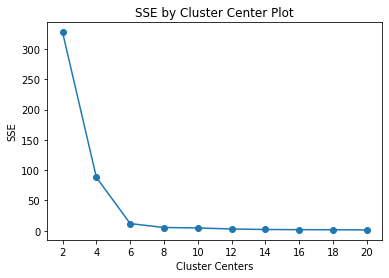

In [20]:
from sklearn.cluster import MiniBatchKMeans
def find_optimal_clusters(df, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(df).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(df_profile, 20)

In [21]:
#instantiate the k-means class, using optimal number of clusters
kmeans = KMeans(init="random", n_clusters=6, n_init=10, random_state=1)

#fit k-means algorithm to data
x = kmeans.fit(df_profile)

#view cluster assignments for each observation
clusters = kmeans.labels_

In [22]:
df['cluster'] = kmeans.labels_

In [23]:
df

,Unnamed: 0,id,first_name,last_name,university_name,education_status,sex,interests,bdate,city_id,city_title,last_seen_platform,last_seen_time,diff_days,years_old,city,cluster
1,1,1361,Anna,Veselova,NaN,NaN,1,NaN,1983-07-24,2.0,Saint Petersburg,2.0,2023-05-22 19:32:28,14554 days 18:53:14.455522,39.849653,0,5
3,3,9088,Sergey,Cherepanov,NaN,NaN,2,NaN,1989-08-23,2.0,Saint Petersburg,4.0,2023-05-22 21:37:36,12332 days 18:53:14.455522,33.766024,0,2
6,6,18619,Oleg,Koresh,NaN,NaN,2,NaN,1987-05-23,2.0,Saint Petersburg,2.0,2023-05-21 17:01:04,13155 days 18:53:14.455522,36.019321,0,2
9,9,38445,Alina,Borodina,NaN,NaN,1,NaN,1989-02-22,2.0,Saint Petersburg,2.0,2023-05-22 20:20:22,12514 days 18:53:14.455522,34.264323,0,5
14,14,73458,Maria,Smirnova,NaN,NaN,1,NaN,1980-06-23,2.0,Saint Petersburg,2.0,2023-05-22 10:27:03,15680 days 18:53:14.455522,42.932537,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3408,3408,744131146,Anna,Ermeni,СПбГУ,NaN,1,NaN,2003-08-30,2.0,Saint Petersburg,4.0,2023-05-22 19:18:54,7212 days 18:53:14.455522,19.747940,0,5
3409,3409,744825520,Ivan,Bushuev,NaN,NaN,2,NaN,2004-08-27,NaN,NaN,2.0,2023-05-22 20:14:37,6849 days 18:53:14.455522,18.754080,2,0
3410,3410,745902835,Madi,Xoja,NaN,NaN,1,NaN,2003-08-10,NaN,NaN,7.0,2023-05-06 15:30:14,7232 days 18:53:14.455522,19.802698,2,1
3427,3427,776095130,Rudi,Troya,NaN,NaN,2,NaN,2000-01-21,NaN,NaN,7.0,2023-05-20 23:06:19,8529 days 18:53:14.455522,23.353764,2,0


In [24]:
from sklearn.decomposition import PCA

# initialize PCA with 2 components
pca = PCA(n_components=2, random_state=42)
# pass our X to the pca and store the reduced vectors into pca_vecs
pca_vecs = pca.fit_transform(df_profile)
# save our two dimensions into x0 and x1
x0 = pca_vecs[:, 0]
x1 = pca_vecs[:, 1]

In [25]:
# assign clusters and pca vectors to our dataframe 
df['cluster'] = clusters
df['x0'] = x0
df['x1'] = x1

In [26]:
df

,Unnamed: 0,id,first_name,last_name,university_name,education_status,sex,interests,bdate,city_id,city_title,last_seen_platform,last_seen_time,diff_days,years_old,city,cluster,x0,x1
1,1,1361,Anna,Veselova,NaN,NaN,1,NaN,1983-07-24,2.0,Saint Petersburg,2.0,2023-05-22 19:32:28,14554 days 18:53:14.455522,39.849653,0,5,0.665690,-0.495131
3,3,9088,Sergey,Cherepanov,NaN,NaN,2,NaN,1989-08-23,2.0,Saint Petersburg,4.0,2023-05-22 21:37:36,12332 days 18:53:14.455522,33.766024,0,2,0.849199,0.907241
6,6,18619,Oleg,Koresh,NaN,NaN,2,NaN,1987-05-23,2.0,Saint Petersburg,2.0,2023-05-21 17:01:04,13155 days 18:53:14.455522,36.019321,0,2,0.849398,0.906573
9,9,38445,Alina,Borodina,NaN,NaN,1,NaN,1989-02-22,2.0,Saint Petersburg,2.0,2023-05-22 20:20:22,12514 days 18:53:14.455522,34.264323,0,5,0.665197,-0.493476
14,14,73458,Maria,Smirnova,NaN,NaN,1,NaN,1980-06-23,2.0,Saint Petersburg,2.0,2023-05-22 10:27:03,15680 days 18:53:14.455522,42.932537,0,5,0.665962,-0.496045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3408,3408,744131146,Anna,Ermeni,СПбГУ,NaN,1,NaN,2003-08-30,2.0,Saint Petersburg,4.0,2023-05-22 19:18:54,7212 days 18:53:14.455522,19.747940,0,5,0.663916,-0.489174
3409,3409,744825520,Ivan,Bushuev,NaN,NaN,2,NaN,2004-08-27,NaN,NaN,2.0,2023-05-22 20:14:37,6849 days 18:53:14.455522,18.754080,2,0,-0.554272,1.095253
3410,3410,745902835,Madi,Xoja,NaN,NaN,1,NaN,2003-08-10,NaN,NaN,7.0,2023-05-06 15:30:14,7232 days 18:53:14.455522,19.802698,2,1,-0.738226,-0.305627
3427,3427,776095130,Rudi,Troya,NaN,NaN,2,NaN,2000-01-21,NaN,NaN,7.0,2023-05-20 23:06:19,8529 days 18:53:14.455522,23.353764,2,0,-0.553866,1.093890


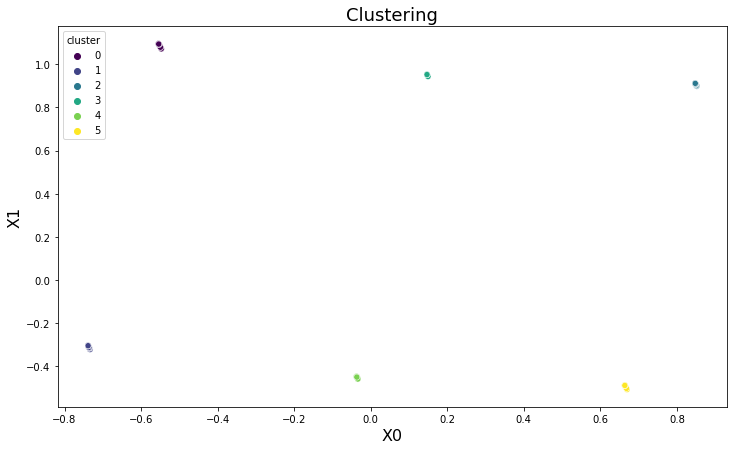

In [27]:
# set image size
plt.figure(figsize=(12, 7))
# set a title
plt.title("Clustering", fontdict={"fontsize": 18})
# set axes names
plt.xlabel("X0", fontdict={"fontsize": 16})
plt.ylabel("X1", fontdict={"fontsize": 16})
# create scatter plot with seaborn, where hue is the class used to group the data
sns.scatterplot(data=df, x='x0', y='x1', hue='cluster', palette="viridis")
plt.show()

In [28]:
df.to_csv('cluster_profile_gsom_bach_3.csv')

## Masters group

In [29]:
df_ma = pd.read_csv('profile_info_gsom_ma.csv')

In [30]:
df_ma =df_ma.loc[df_ma['last_seen_time'] >= '2022-06-01']

In [31]:
df_ma = df_ma.loc[df_ma['bdate'].str.len() == 9]

In [32]:
curr_time = pd.to_datetime("now")
print(curr_time)

2023-05-29 18:53:15.723707


In [33]:
df_ma['bdate'] = pd.to_datetime(df_ma.bdate, format='%d.%m.%Y')

In [34]:
df_ma['diff_days'] = curr_time - df_ma['bdate']
# for days use 'D' for weeks use 'W', for month use 'M' and for years use 'Y'
df_ma['years_old']=df_ma['diff_days']/np.timedelta64(1,'Y')      
print(df_ma)

      Unnamed: 0         id first_name     last_name  sex  \
11            11      16918      Kolya       Semakov    2   
12            12      18619       Oleg        Koresh    2   
14            14      22699    Mikhail       Andreev    2   
16            16      28554   Katerina        Serova    1   
18            18      31439   Gefestia  Makedonskaya    1   
...          ...        ...        ...           ...  ...   
3071        3071  745902835       Madi          Xoja    1   
3074        3074  748889156      Artur     Ibragimov    2   
3076        3076  753689596     Nguyen          Tung    2   
3079        3079  765417833         Go        Galina    1   
3081        3081  800818601     Saymon         Rayli    2   

                                                       interests      bdate  \
11                                                           NaN 1989-05-17   
12                                                           NaN 1987-05-23   
14    Плавание, бильярд, форму

In [35]:
df_ma = df_ma.dropna(subset=['bdate'])
df_ma

,Unnamed: 0,id,first_name,last_name,sex,interests,bdate,city_id,city_title,last_seen_platform,last_seen_time,diff_days,years_old
11,11,16918,Kolya,Semakov,2,NaN,1989-05-17,2.0,Saint Petersburg,2.0,2023-05-21 02:11:33,12430 days 18:53:15.723707,34.034339
12,12,18619,Oleg,Koresh,2,NaN,1987-05-23,2.0,Saint Petersburg,2.0,2023-05-21 17:01:04,13155 days 18:53:15.723707,36.019321
14,14,22699,Mikhail,Andreev,2,"Плавание, бильярд, формула, футбол, велосипед., Марафон!!!",1985-08-19,2.0,Saint Petersburg,4.0,2023-05-21 21:41:32,13797 days 18:53:15.723707,37.777058
16,16,28554,Katerina,Serova,1,NaN,1989-07-16,1711047.0,Seattle,2.0,2023-05-20 00:43:19,12370 days 18:53:15.723707,33.870064
18,18,31439,Gefestia,Makedonskaya,1,NaN,1989-01-19,2.0,Saint Petersburg,2.0,2023-05-21 17:07:23,12548 days 18:53:15.723707,34.357412
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3071,3071,745902835,Madi,Xoja,1,NaN,2003-08-10,NaN,NaN,7.0,2023-05-06 15:30:14,7232 days 18:53:15.723707,19.802698
3074,3074,748889156,Artur,Ibragimov,2,NaN,1992-05-25,2.0,Saint Petersburg,2.0,2023-05-21 18:21:40,11326 days 18:53:15.723707,31.011689
3076,3076,753689596,Nguyen,Tung,2,NaN,1998-06-23,2.0,Saint Petersburg,4.0,2023-05-21 18:42:43,9106 days 18:53:15.723707,24.933536
3079,3079,765417833,Go,Galina,1,NaN,2001-03-12,NaN,NaN,4.0,2023-05-21 07:30:33,8113 days 18:53:15.723707,22.214794


In [36]:
df_ma = df_ma.loc[df_ma['years_old'] <= 100]

In [37]:
Conditions = [
    (df_ma['city_title'] == 'Saint Petersburg'),
    (df_ma['city_title'] == 'Moscow'),
    (df_ma['city_title'] != 'Saint Petersburg')& (df_ma['city_title'] != 'Moscow')
]
Categories = ['0', '1', '2']
df_ma['city'] = np.select(Conditions, Categories)

/tmp/ipykernel_185/3326130093.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ma['city'] = np.select(Conditions, Categories)


In [38]:
df_ma = df_ma.dropna(subset=['city'])
df_ma.shape

(518, 14)

In [39]:
df_profile_ma = df_ma[["sex", "years_old","city"]]

In [40]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
df_profile_ma[['years_old']] = scaler.fit_transform(df_profile_ma[['years_old']])

/opt/conda/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [41]:
df_profile_ma = pd.get_dummies(df_profile_ma, columns=["sex", "city"])

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters


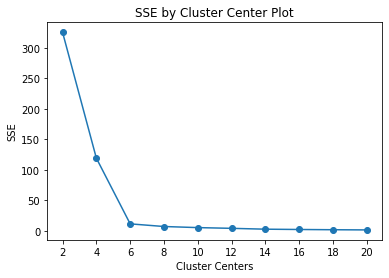

In [42]:
find_optimal_clusters(df_profile_ma, 20)

In [43]:
#instantiate the k-means class, using optimal number of clusters
kmeans_ma = KMeans(init="random", n_clusters=6, n_init=10, random_state=1)

#fit k-means algorithm to data
x = kmeans_ma.fit(df_profile_ma)

#view cluster assignments for each observation
clusters = kmeans_ma.labels_

In [44]:
df_ma['cluster'] = kmeans_ma.labels_

In [45]:
df_ma

,Unnamed: 0,id,first_name,last_name,sex,interests,bdate,city_id,city_title,last_seen_platform,last_seen_time,diff_days,years_old,city,cluster
11,11,16918,Kolya,Semakov,2,NaN,1989-05-17,2.0,Saint Petersburg,2.0,2023-05-21 02:11:33,12430 days 18:53:15.723707,34.034339,0,2
12,12,18619,Oleg,Koresh,2,NaN,1987-05-23,2.0,Saint Petersburg,2.0,2023-05-21 17:01:04,13155 days 18:53:15.723707,36.019321,0,2
14,14,22699,Mikhail,Andreev,2,"Плавание, бильярд, формула, футбол, велосипед., Марафон!!!",1985-08-19,2.0,Saint Petersburg,4.0,2023-05-21 21:41:32,13797 days 18:53:15.723707,37.777058,0,2
16,16,28554,Katerina,Serova,1,NaN,1989-07-16,1711047.0,Seattle,2.0,2023-05-20 00:43:19,12370 days 18:53:15.723707,33.870064,2,5
18,18,31439,Gefestia,Makedonskaya,1,NaN,1989-01-19,2.0,Saint Petersburg,2.0,2023-05-21 17:07:23,12548 days 18:53:15.723707,34.357412,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3071,3071,745902835,Madi,Xoja,1,NaN,2003-08-10,NaN,NaN,7.0,2023-05-06 15:30:14,7232 days 18:53:15.723707,19.802698,2,5
3074,3074,748889156,Artur,Ibragimov,2,NaN,1992-05-25,2.0,Saint Petersburg,2.0,2023-05-21 18:21:40,11326 days 18:53:15.723707,31.011689,0,2
3076,3076,753689596,Nguyen,Tung,2,NaN,1998-06-23,2.0,Saint Petersburg,4.0,2023-05-21 18:42:43,9106 days 18:53:15.723707,24.933536,0,2
3079,3079,765417833,Go,Galina,1,NaN,2001-03-12,NaN,NaN,4.0,2023-05-21 07:30:33,8113 days 18:53:15.723707,22.214794,2,5


In [46]:
from sklearn.decomposition import PCA

# initialize PCA with 2 components
pca = PCA(n_components=2, random_state=42)
# pass our X to the pca and store the reduced vectors into pca_vecs
pca_vecs = pca.fit_transform(df_profile_ma)
# save our two dimensions into x0 and x1
x0 = pca_vecs[:, 0]
x1 = pca_vecs[:, 1]

In [47]:
# assign clusters and pca vectors to our dataframe 
df_ma['cluster'] = clusters
df_ma['x0'] = x0
df_ma['x1'] = x1

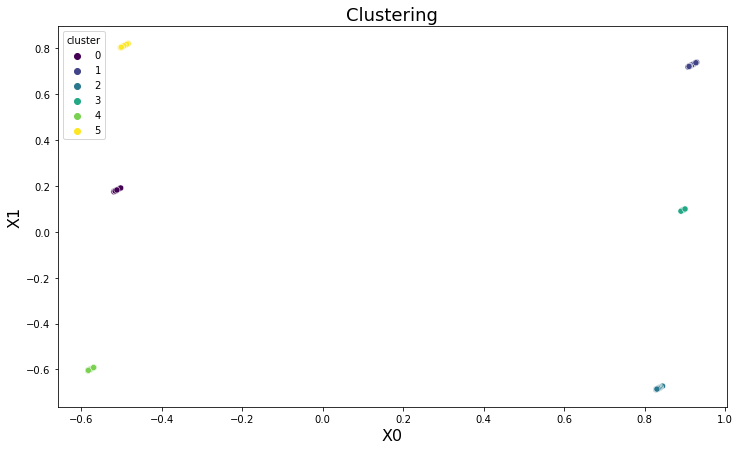

In [48]:
# set image size
plt.figure(figsize=(12, 7))
# set a title
plt.title("Clustering", fontdict={"fontsize": 18})
# set axes names
plt.xlabel("X0", fontdict={"fontsize": 16})
plt.ylabel("X1", fontdict={"fontsize": 16})
# create scatter plot with seaborn, where hue is the class used to group the data
sns.scatterplot(data=df_ma, x='x0', y='x1', hue='cluster', palette="viridis")
plt.show()

In [49]:
df_ma.to_csv('cluster_profile_gsom_ma3.csv')

## Общая группа

In [50]:
df_gsom_spbu = pd.read_csv('profile_info_gsom_spbu.csv')

In [51]:
df_gsom_spbu =df_gsom_spbu.loc[df_gsom_spbu['last_seen_time'] >= '2022-06-01']

In [52]:
df_gsom_spbu = df_gsom_spbu.loc[df_gsom_spbu['bdate'].str.len() == 9]

In [53]:
curr_time = pd.to_datetime("now")
print(curr_time)

2023-05-29 18:53:16.805574


In [54]:
df_gsom_spbu['bdate'] = pd.to_datetime(df_gsom_spbu.bdate, format='%d.%m.%Y')

In [55]:
df_gsom_spbu['diff_days'] = curr_time - df_gsom_spbu['bdate']
# for days use 'D' for weeks use 'W', for month use 'M' and for years use 'Y'
df_gsom_spbu['years_old']=df_gsom_spbu['diff_days']/np.timedelta64(1,'Y')      
print(df_gsom_spbu)

       Unnamed: 0         id first_name   last_name  sex  \
3               3        292       Anna     Chupira    1   
5               5        324  Anastasia    Loginova    1   
10             10        651   Katerina      Shoman    1   
13             13        856      Misha  Scherbakov    2   
14             14        892     Galina    Morozova    1   
...           ...        ...        ...         ...  ...   
12548       12548  779737630  Anastasia   Voronkova    1   
12552       12552  786151418    Aleksei       Marks    2   
12555       12555  793675175      Arina    Karenina    1   
12556       12556  796623287      Yarar     Yararov    2   
12557       12557  799623825  Abdulaziz     Akbarov    2   

                          interests      bdate  city_id        city_title  \
3                               NaN 1985-03-18      2.0  Saint Petersburg   
5                               NaN 1988-01-12      1.0            Moscow   
10                              NaN 1988-03-11  

In [56]:
df_gsom_spbu = df_gsom_spbu.dropna(subset=['bdate'])
df_gsom_spbu

,Unnamed: 0,id,first_name,last_name,sex,interests,bdate,city_id,city_title,last_seen_platform,last_seen_time,diff_days,years_old
3,3,292,Anna,Chupira,1,NaN,1985-03-18,2.0,Saint Petersburg,2.0,2023-05-23 20:24:15,13951 days 18:53:16.805574,38.198695
5,5,324,Anastasia,Loginova,1,NaN,1988-01-12,1.0,Moscow,7.0,2023-05-23 09:36:56,12921 days 18:53:16.805574,35.378651
10,10,651,Katerina,Shoman,1,NaN,1988-03-11,1.0,Moscow,2.0,2023-05-02 21:18:41,12862 days 18:53:16.805574,35.217115
13,13,856,Misha,Scherbakov,2,NaN,1983-08-19,1.0,Moscow,2.0,2023-05-23 12:42:30,14528 days 18:53:16.805574,39.778468
14,14,892,Galina,Morozova,1,NaN,1983-03-19,2.0,Saint Petersburg,2.0,2023-05-23 22:46:08,14681 days 18:53:16.805574,40.197368
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12548,12548,779737630,Anastasia,Voronkova,1,NaN,1999-02-24,2.0,Saint Petersburg,7.0,2023-05-23 14:01:44,8860 days 18:53:16.805574,24.260011
12552,12552,786151418,Aleksei,Marks,2,"Экономика, Философия, Бизнес",1999-11-02,2.0,Saint Petersburg,4.0,2023-05-23 19:37:32,8609 days 18:53:16.805574,23.572796
12555,12555,793675175,Arina,Karenina,1,NaN,2001-09-17,NaN,NaN,1.0,2023-05-23 19:04:59,7924 days 18:53:16.805574,21.697330
12556,12556,796623287,Yarar,Yararov,2,NaN,2003-10-01,60.0,Kazan,7.0,2023-05-23 15:42:37,7180 days 18:53:16.805574,19.660327


In [57]:
df_gsom_spbu = df_gsom_spbu.loc[df_gsom_spbu['years_old'] <= 100]

In [58]:
Conditions = [
    (df_gsom_spbu['city_title'] == 'Saint Petersburg'),
    (df_gsom_spbu['city_title'] == 'Moscow'),
    (df_gsom_spbu['city_title'] != 'Saint Petersburg')& (df_gsom_spbu['city_title'] != 'Moscow')
]
Categories = ['0', '1', '2']
df_gsom_spbu['city'] = np.select(Conditions, Categories)

/tmp/ipykernel_185/1493133264.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gsom_spbu['city'] = np.select(Conditions, Categories)


In [59]:
df_gsom_spbu = df_gsom_spbu.dropna(subset=['city'])
df_gsom_spbu.shape

(1730, 14)

In [60]:
df_profile_gsom_spbu = df_gsom_spbu[["sex", "years_old", "city"]]

In [61]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
df_profile_gsom_spbu[['years_old']] = scaler.fit_transform(df_profile_gsom_spbu[['years_old']])

/opt/conda/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [62]:
df_profile_gsom_spbu = pd.get_dummies(df_profile_gsom_spbu, columns=["sex", "city"])

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters


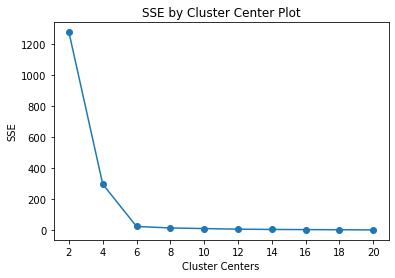

In [63]:
find_optimal_clusters(df_profile_gsom_spbu, 20)

In [64]:
#instantiate the k-means class, using optimal number of clusters
kmeans_all = KMeans(init="random", n_clusters=6, n_init=10, random_state=1)

#fit k-means algorithm to data
x = kmeans_all.fit(df_profile_gsom_spbu)

#view cluster assignments for each observation
clusters = kmeans_all.labels_

In [65]:
df_gsom_spbu['cluster'] = kmeans_all.labels_

In [66]:
from sklearn.decomposition import PCA

# initialize PCA with 2 components
pca = PCA(n_components=2, random_state=42)
# pass our X to the pca and store the reduced vectors into pca_vecs
pca_vecs = pca.fit_transform(df_profile_gsom_spbu)
# save our two dimensions into x0 and x1
x0 = pca_vecs[:, 0]
x1 = pca_vecs[:, 1]

In [67]:
# assign clusters and pca vectors to our dataframe 
df_gsom_spbu['cluster'] = clusters
df_gsom_spbu['x0'] = x0
df_gsom_spbu['x1'] = x1

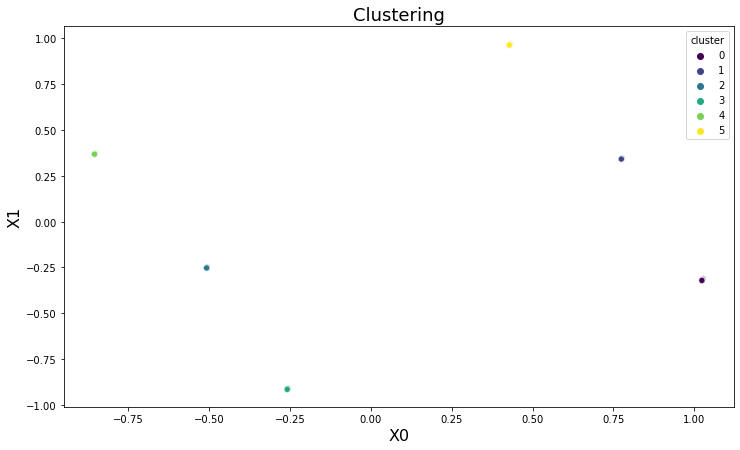

In [68]:
# set image size
plt.figure(figsize=(12, 7))
# set a title
plt.title("Clustering", fontdict={"fontsize": 18})
# set axes names
plt.xlabel("X0", fontdict={"fontsize": 16})
plt.ylabel("X1", fontdict={"fontsize": 16})
# create scatter plot with seaborn, where hue is the class used to group the data
sns.scatterplot(data=df_gsom_spbu, x='x0', y='x1', hue='cluster', palette="viridis")
plt.show()

In [69]:
df_gsom_spbu.to_csv('cluster_profile_gsom_all3.csv')

In [70]:
cluster4 = df_gsom_spbu.loc[df_gsom_spbu['cluster'] == 0]
print(cluster4['sex'].value_counts())
print(cluster4['city'].value_counts())

2    345
Name: sex, dtype: int64
2    345
Name: city, dtype: int64


In [71]:
cluster4['years_old'].describe()

count    345.000000
mean      30.702877
std        9.942730
min       15.769761
25%       24.840447
50%       29.221098
75%       34.212303
max       98.257423
Name: years_old, dtype: float64